# Weather Data Preprocessing - Step 2

This notebook follows Step 1 (outlier detection and removal) and focuses on:

1. Weather data preprocessing
2. Feature engineering
3. Exploring the processed data and checking for missing values
4. Saving the final processed dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
from datetime import datetime, timedelta
import warnings

# Enable autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

# Add parent directory to path
sys.path.append('..')

# Suppress warnings
warnings.filterwarnings('ignore')

# Set Matplotlib style
plt.style.use('seaborn-v0_8-whitegrid')

# Import our modules
from src.weather.preprocess import prepare_weather_data
from src.weather.features import engineer_weather_features

## 1. Load and Preprocess Weather Data

First, we'll load the weather data for Saint Petersburg and apply the basic preprocessing steps.

In [2]:
# Define path to data folder and weather file
weather_file = '../data/weather_spb_2023.csv'

# Preprocess the weather data
df_weather = prepare_weather_data(weather_file, reset_index=True)

print(f"Weather data shape after preprocessing: {df_weather.shape}")
df_weather.head()

2025-04-24 05:15:39,790 - src.weather.preprocess - INFO - Loading weather data from ../data/weather_spb_2023.csv
2025-04-24 05:15:39,796 - src.weather.preprocess - INFO - Loaded weather data: 365 rows, 33 columns
2025-04-24 05:15:39,796 - src.weather.preprocess - INFO - Cleaning weather data
2025-04-24 05:15:39,808 - src.weather.preprocess - INFO - Cleaned weather data: (365, 34)
2025-04-24 05:15:39,808 - src.weather.preprocess - INFO - Extracting date features
2025-04-24 05:15:39,810 - src.weather.preprocess - INFO - Extracted date features: (365, 46)
2025-04-24 05:15:39,813 - src.weather.preprocess - INFO - Weather data preprocessing completed


Weather data shape after preprocessing: (365, 47)


,calday,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,precip,...,day,day_of_week,day_of_year,is_weekend,quarter,season,month_sin,month_cos,day_of_year_sin,day_of_year_cos
0,2023-01-01,5.0,-2.0,1.9,0.9,-7.4,-2.3,0.1,88.1,0.505,...,1,6,1,True,1,winter,0.5,0.866025,0.017213,0.999852
1,2023-01-02,0.0,-4.0,-1.4,-2.5,-8.5,-5.7,-3.9,83.7,0.000,...,2,0,2,False,1,winter,0.5,0.866025,0.034422,0.999407
2,2023-01-03,-1.0,-3.0,-2.3,-2.0,-9.3,-6.4,-4.0,88.2,1.425,...,3,1,3,False,1,winter,0.5,0.866025,0.051620,0.998667
3,2023-01-04,-2.0,-12.0,-4.4,-2.4,-17.9,-7.6,-6.9,83.1,2.698,...,4,2,4,False,1,winter,0.5,0.866025,0.068802,0.997630
4,2023-01-05,-8.9,-17.0,-12.0,-8.9,-21.2,-15.7,-15.1,77.7,1.019,...,5,3,5,False,1,winter,0.5,0.866025,0.085965,0.996298


## 2. Engineer Weather Features

Now we'll create features for our model, making sure to only use data from 14+ days in the past since we have a 14-day forecast horizon.

In [3]:
# Engineer features with forecast horizon constraints
df_features = engineer_weather_features(
    df_weather,
    date_col='calday'
)

print(f"Weather data shape after feature engineering: {df_features.shape}")
print(f"Total number of features: {len(df_features.columns)}")

2025-04-24 05:15:39,846 - src.weather.features - WARNING - Some lag days are less than 14 days. These may not be available at prediction time.
2025-04-24 05:15:39,847 - src.weather.features - INFO - Creating lag features (14+ days) for 20 columns
2025-04-24 05:15:39,853 - src.weather.features - INFO - Created 40 lag features
2025-04-24 05:15:39,853 - src.weather.features - INFO - Creating forecast-safe rolling features for 20 columns
2025-04-24 05:15:40,044 - src.weather.features - INFO - Created forecast-safe rolling features
2025-04-24 05:15:40,045 - src.weather.features - INFO - Creating past extreme weather indicators
2025-04-24 05:15:40,068 - src.weather.features - INFO - Created past extreme weather indicators
2025-04-24 05:15:40,068 - src.weather.features - INFO - Creating temperature features
2025-04-24 05:15:40,070 - src.weather.features - INFO - Created temperature features
2025-04-24 05:15:40,070 - src.weather.features - INFO - Filling missing values
2025-04-24 05:15:40,110 

Weather data shape after feature engineering: (365, 449)
Total number of features: 449


## 3. Explore the Processed Dataset

Let's examine the columns in our processed dataset and check the data types.

In [4]:
# Display column information
print("Column data types:")
print(df_features.dtypes.sort_values().value_counts())

# Show columns by category
col_categories = {
    "Base features": [col for col in df_features.columns if not ('_' in col)],
    "Lag features": [col for col in df_features.columns if '_lag_' in col],
    "Window features": [col for col in df_features.columns if '_d14to' in col],
    "Binary features": list(df_features.select_dtypes(include=['bool']).columns)
}

# Print column counts by category
print("\nColumn counts by category:")
for category, cols in col_categories.items():
    print(f"{category}: {len(cols)} columns")

# Print example columns from each category
print("\nExample columns from each category:")
for category, cols in col_categories.items():
    if cols:
        print(f"\n{category}:")
        for col in sorted(cols)[:5]:  # Show just 5 examples
            print(f"  - {col}")
        if len(cols) > 5:
            print(f"  - ... ({len(cols)-5} more)")

Column data types:
float64           388
bool               33
int64              20
int32               6
datetime64[ns]      1
object              1
Name: count, dtype: int64

Column counts by category:
Base features: 29 columns
Lag features: 40 columns
Window features: 36 columns
Binary features: 33 columns

Example columns from each category:

Base features:
  - calday
  - cloudcover
  - day
  - dew
  - feelslike
  - ... (24 more)

Lag features:
  - cloudcover_lag_14d
  - cloudcover_lag_28d
  - daylight_hours_lag_14d
  - daylight_hours_lag_28d
  - feelslike_lag_14d
  - ... (35 more)

Window features:
  - precip_had_high_d14to28
  - precip_had_high_d14to42
  - precip_high_days_d14to28
  - precip_high_days_d14to42
  - snow_had_high_d14to28
  - ... (31 more)

Binary features:
  - cold_day
  - freezing_day
  - has_precipitation
  - has_rain
  - has_snow
  - ... (28 more)


## 4. Sample Data Preview

Let's look at some sample data across different feature categories.

In [5]:
# Select a representative sample of columns to display
sample_columns = [
    # Date and base features
    'calday', 'temp', 'tempmax', 'tempmin', 'precip', 'cloudcover', 'humidity',
    
    # Lag features (14+ days)
    'temp_lag_14d', 'precip_lag_14d', 'cloudcover_lag_14d',
    
    # Rolling window features
    'temp_d14to28_mean', 'precip_d14to28_mean', 
    
    # Binary features
    'has_rain', 'has_snow', 'freezing_day'
]

# Filter to only columns that exist in our dataframe
existing_columns = [col for col in sample_columns if col in df_features.columns]

# Display the selected columns
print("Sample data preview:")
df_features[existing_columns].head(10)

Sample data preview:


,calday,temp,tempmax,tempmin,precip,cloudcover,humidity,temp_lag_14d,precip_lag_14d,cloudcover_lag_14d,has_rain,has_snow,freezing_day
0,2023-01-01,1.9,5.0,-2.0,0.505,83.0,88.1,6.783014,1.962222,71.521918,True,False,True
1,2023-01-02,-1.4,0.0,-4.0,0.000,57.4,83.7,6.783014,1.962222,71.521918,False,False,True
2,2023-01-03,-2.3,-1.0,-3.0,1.425,95.0,88.2,6.783014,1.962222,71.521918,True,True,True
3,2023-01-04,-4.4,-2.0,-12.0,2.698,91.5,83.1,6.783014,1.962222,71.521918,False,True,True
4,2023-01-05,-12.0,-8.9,-17.0,1.019,74.8,77.7,6.783014,1.962222,71.521918,False,True,True
5,2023-01-06,-10.9,-7.0,-17.0,2.758,90.7,79.0,6.783014,1.962222,71.521918,False,True,True
6,2023-01-07,-10.4,-7.8,-17.0,0.200,85.5,73.0,6.783014,1.962222,71.521918,False,True,True
7,2023-01-08,-16.9,-13.0,-21.0,0.000,89.2,70.2,6.783014,1.962222,71.521918,False,False,True
8,2023-01-09,-10.6,-9.0,-13.0,0.018,81.1,70.5,6.783014,1.962222,71.521918,False,True,True
9,2023-01-10,-7.0,-2.0,-10.0,1.884,97.2,72.3,6.783014,1.962222,71.521918,False,True,True


## 5. Check for Missing Values

Now let's check for any missing values in our dataset that might need attention.

In [6]:
# Check for missing values in all columns
missing_values = df_features.isna().sum()
missing_columns = missing_values[missing_values > 0]

if len(missing_columns) > 0:
    print("Columns with missing values:")
    print(missing_columns.sort_values(ascending=False))
    
    # Calculate percentage of missing values
    missing_percentage = (missing_columns / len(df_features)) * 100
    print("\nPercentage of missing values:")
    print(missing_percentage.sort_values(ascending=False))
    
    # Visualize missing values if there are any
    plt.figure(figsize=(10, 6))
    plt.bar(missing_percentage.index[:20], missing_percentage.values[:20], color='salmon')
    plt.title('Top 20 Columns with Missing Values')
    plt.xlabel('Column')
    plt.ylabel('Percentage Missing')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
else:
    print("No missing values found in the dataset!")

No missing values found in the dataset!


## 6. Visualize Key Weather Features

Let's visualize some of the key weather features and their lagged versions.

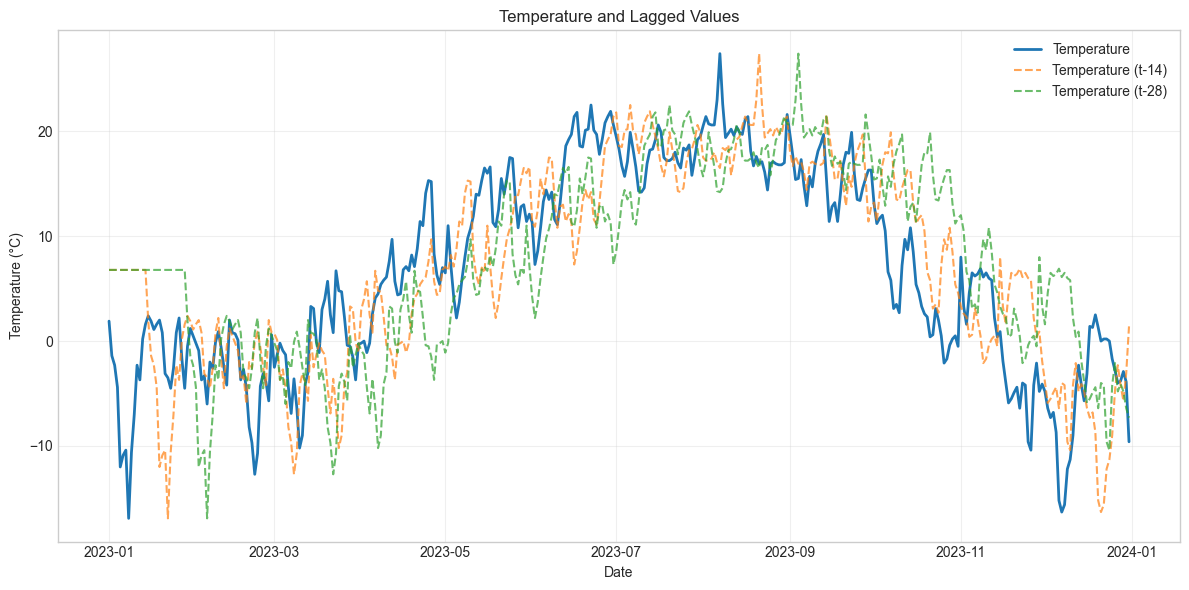

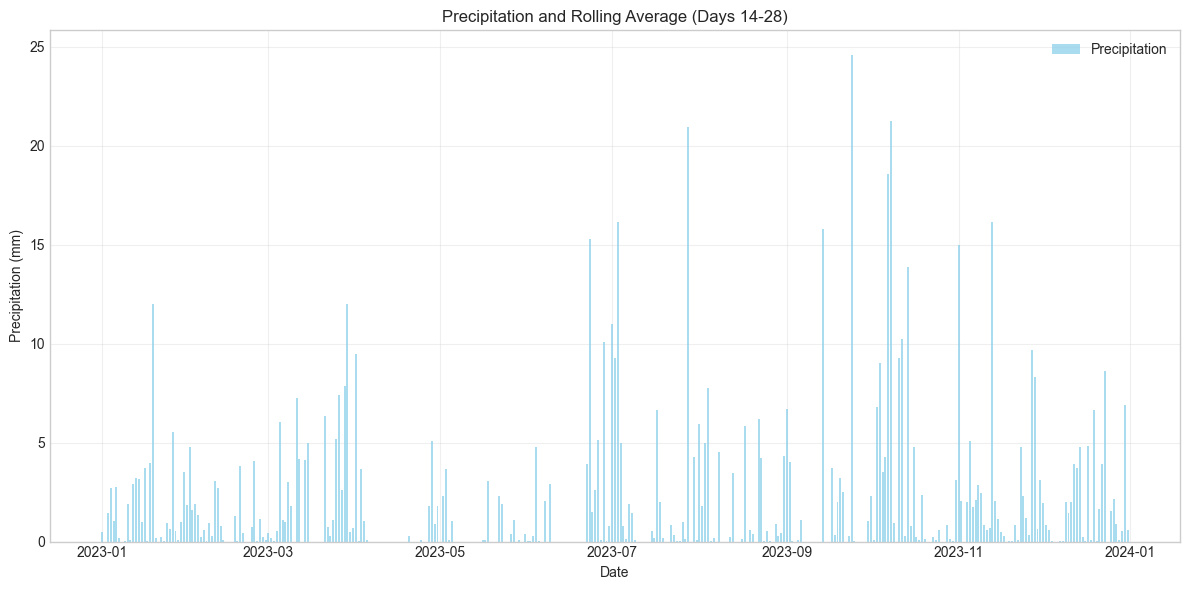

In [7]:
# Set calday as index for time series plots
df_plot = df_features.set_index('calday')

# Example plot: temperature with its lagged versions
plt.figure(figsize=(12, 6))
plt.plot(df_plot.index, df_plot['temp'], label='Temperature', linewidth=2)

# Plot lag features if they exist
for lag in [14, 28]:
    lag_col = f'temp_lag_{lag}d'
    if lag_col in df_plot.columns:
        plt.plot(df_plot.index, df_plot[lag_col], label=f'Temperature (t-{lag})', linestyle='--', alpha=0.7)

plt.title('Temperature and Lagged Values')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Example plot: precipitation with its lagged versions
plt.figure(figsize=(12, 6))
plt.bar(df_plot.index, df_plot['precip'], label='Precipitation', color='skyblue', alpha=0.7, width=0.7)

# Plot rolling mean if it exists
if 'precip_d14to28_mean' in df_plot.columns:
    plt.plot(df_plot.index, df_plot['precip_d14to28_mean'], label='14-28 Day Avg', color='blue', linewidth=2)

plt.title('Precipitation and Rolling Average (Days 14-28)')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Save Processed Weather Data

Finally, let's save the processed weather data for use in our machine learning models.

In [8]:
# Save to CSV file
output_path = '../data/weather.csv'
df_features.to_csv(output_path, index=False)
print(f"Saved processed weather data to {output_path}")
print(f"Final dataset shape: {df_features.shape}")

# Summary statistics
print("\nSummary of key features:")
summary_cols = ['temp', 'precip', 'cloudcover', 'humidity']
summary_cols = [col for col in summary_cols if col in df_features.columns]
print(df_features[summary_cols].describe())

print("\nProcessing complete! The weather dataset is now ready for modeling.")

Saved processed weather data to ../data/weather_processed.csv
Final dataset shape: (365, 449)

Summary of key features:
             temp      precip  cloudcover    humidity
count  365.000000  365.000000  365.000000  365.000000
mean     6.783014    1.962222   71.521918   75.484110
std      9.653846    3.591673   23.244184   12.670385
min    -16.900000    0.000000    2.200000   36.400000
25%     -0.900000    0.000000   56.300000   68.000000
50%      6.200000    0.333000   76.200000   77.300000
75%     16.000000    2.322000   92.300000   85.500000
max     27.400000   24.597000  100.000000   95.900000

Processing complete! The weather dataset is now ready for modeling.
